In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import find_peaks

lowest_freq = 70  # Minimum valid frequency for fundamental detection
highest_freq = 1000

def estimate_fundamental(peaks, power_values):
    """Finds the approximate fundamental frequency from detected peaks using an approximate GCD method.
    
    Removes peaks that are too close together (< 68 Hz), keeping the stronger peak. 
    After estimating the fundamental frequency, checks whether all remaining peaks are integer multiples of it.
    """
    filter_threshold = 0.4
    npeaks_unfiltered = len(peaks)
    
    # Sort peaks and power values together
    sorted_indices = np.argsort(peaks)
    peaks_sorted = peaks[sorted_indices]
    power_sorted = power_values[sorted_indices]
    
    removed_peaks = []  # Store removed peaks for plotting
    removed_power = []

    # Iteratively remove peaks that are too close (< 68 Hz)
    while True:
        if len(peaks_sorted) < 2:
            break
        
        spacings = np.diff(peaks_sorted)
        min_spacing_idx = np.argmin(spacings)
        min_spacing = spacings[min_spacing_idx]

        if min_spacing >= lowest_freq:
            break
        
        # Determine which peak to remove (weaker one)
        if power_sorted[min_spacing_idx] < power_sorted[min_spacing_idx + 1]:
            remove_idx = min_spacing_idx
        else:
            remove_idx = min_spacing_idx + 1

        # Store removed peaks for visualization
        removed_peaks.append(peaks_sorted[remove_idx])
        removed_power.append(power_sorted[remove_idx])

        # Remove the peak with lower power
        peaks_sorted = np.delete(peaks_sorted, remove_idx)
        power_sorted = np.delete(power_sorted, remove_idx)

    npeaks_filtered = len(peaks_sorted)
    filter_reduction = npeaks_filtered / npeaks_unfiltered
    if filter_reduction < filter_threshold:
        return None, None, removed_peaks, removed_power
    
    if len(peaks_sorted) == 1:
        estimated_fundamental = peaks_sorted[0]
        if lowest_freq <= estimated_fundamental <= highest_freq:
            return peaks_sorted, peaks_sorted[0], removed_peaks, removed_power
        else:
            return None, None, removed_peaks, removed_power
    
    # Compute frequency differences
    spacings = np.diff(peaks_sorted)
    min_spacing = np.min(spacings)
    multiples = spacings / min_spacing

    threshold = 0.05
    rounded_multiples = np.round(multiples)
    valid_multiples = rounded_multiples[np.abs(multiples - rounded_multiples) <= threshold]

    # Filter spacings and divide by corresponding valid multiples
    valid_indices = np.abs(multiples - rounded_multiples) <= threshold
    filtered_spacings = spacings[valid_indices]
    normalized_spacings = filtered_spacings / valid_multiples

    # Compute the average of normalized spacings
    if len(normalized_spacings) > 0:
        estimated_fundamental = np.mean(normalized_spacings)
    else:
        return None, None, removed_peaks, removed_power

    # **Final Validation: Check if all peaks are integer multiples of the fundamental**
    peak_multiples = peaks_sorted / estimated_fundamental
    rounded_peak_multiples = np.round(peak_multiples)
    valid_peak_multiples = np.abs(peak_multiples - rounded_peak_multiples) <= threshold

    if not np.all(valid_peak_multiples):
        return None, None, removed_peaks, removed_power

    if lowest_freq <= estimated_fundamental <= highest_freq:
        return peaks_sorted, estimated_fundamental, removed_peaks, removed_power
    else:    
        return None, None, removed_peaks, removed_power

In [ ]:
import os
import numpy as np
from scipy.io import wavfile
from scipy.signal import find_peaks
from lookups import note_to_frequency, note_to_fretboard  # Import dictionaries

# Configuration
samples_dir = "samples"
segment_duration = 0.5  # in seconds
lowest_freq = 70  # Minimum fundamental frequency
highest_freq = 1000  # Maximum frequency to consider
fluctuation_tolerance = 2.0  # Allowed difference from actual note frequency (Hz)

# Reverse `note_to_fretboard` so we can map frequencies directly to fretboard locations
fretboard_to_note = {fretboard_pos: note for note, positions in note_to_fretboard.items() for fretboard_pos in positions}

# Function to classify a frequency as a fretboard position
def classify_note(frequency):
    """Finds the closest matching fretboard position for a given frequency."""
    if frequency is None:
        return None
    
    # Find the closest note
    closest_note = min(note_to_frequency, key=lambda note: abs(note_to_frequency[note] - frequency))

    # Map to the correct fretboard position(s)
    return closest_note

# Function to process a single file
def process_wav_file(filename):
    """Processes a .wav file, estimates fundamental frequencies, and calculates accuracy."""
    filepath = os.path.join(samples_dir, filename)
    
    # Load WAV file
    sample_rate, data = wavfile.read(filepath)

    # Convert to mono if stereo
    if len(data.shape) > 1:
        data = np.mean(data, axis=1)

    # Define segment size
    samples_per_segment = int(round(segment_duration * sample_rate))

    # Trim data to be a multiple of the segment duration
    num_segments = len(data) // samples_per_segment
    if num_segments == 0:
        print(f"Skipping {filename}: Too short for segment duration {segment_duration}s", flush=True)
        return None

    trimmed_data = data[:num_segments * samples_per_segment]

    # Determine the correct fretboard position for this file
    expected_note = fretboard_to_note[filename.replace(".wav", "")]

    correct_count, total_count = 0, 0
    predictions = []

    # Process each segment
    for i in range(num_segments):
        segment = trimmed_data[i * samples_per_segment : (i + 1) * samples_per_segment]

        # Compute FFT
        fft_result = np.fft.fft(segment)
        freqs = np.fft.fftfreq(len(segment), 1 / sample_rate)
        print(f"freq interval: {freqs[1] - freqs[0]}")

        # Get power spectrum (magnitude squared of FFT)
        power_spectrum = np.abs(fft_result) ** 2

        # Only keep frequencies up to the set limit
        mask = (freqs >= 0) & (freqs <= highest_freq)
        freqs = freqs[mask]
        power_spectrum = power_spectrum[mask]

        # Find prominent peaks in the power spectrum
        peak_indices, _ = find_peaks(power_spectrum, height=max(power_spectrum) * 0.1)
        peak_frequencies = freqs[peak_indices]
        power_values = power_spectrum[peak_indices]

        # Estimate fundamental frequency
        _, estimated_fundamental, _, _ = estimate_fundamental(peak_frequencies, power_values)

        # Classify estimated fundamental frequency as a fretboard position
        predicted_note = classify_note(estimated_fundamental)

        # Record prediction if valid
        if predicted_note is not None:
            total_count += 1
            predictions.append(predicted_note)

            # Check if the prediction matches the expected fretboard position
            if predicted_note == expected_note:
                correct_count += 1

        # Print progress for each segment
        print(f"Processing {filename}: Segment {i+1}/{num_segments} → "
              f"Predicted: {predicted_note}, Expected: {expected_note}")

    # Calculate accuracy
    if total_count > 0:
        accuracy = correct_count / total_count
    else:
        accuracy = None  # No valid predictions

    print(f"{filename} Accuracy: {accuracy:.2%}\n" if accuracy is not None else f"{filename}: No valid predictions\n", flush=True)
    
    return accuracy

# Process all .wav files in the samples directory
wav_files = sorted([f for f in os.listdir(samples_dir) if f.endswith(".wav")])
accuracies = []

for wav_file in wav_files:
    accuracy = process_wav_file(wav_file)
    if accuracy is not None:
        accuracies.append(accuracy)

# Compute overall accuracy
if accuracies:
    overall_accuracy = np.mean(accuracies)
    print(f"\nOverall Accuracy: {overall_accuracy:.2%}", flush=True)
else:
    print("\nNo valid predictions for any files.", flush=True)


freq interval: 5.0
Processing A_0.wav: Segment 1/25 → Predicted: None, Expected: A2
freq interval: 5.0
Processing A_0.wav: Segment 2/25 → Predicted: None, Expected: A2
freq interval: 5.0
Processing A_0.wav: Segment 3/25 → Predicted: None, Expected: A2
freq interval: 5.0
Processing A_0.wav: Segment 4/25 → Predicted: G#2, Expected: A2
freq interval: 5.0
Processing A_0.wav: Segment 5/25 → Predicted: None, Expected: A2
freq interval: 5.0
Processing A_0.wav: Segment 6/25 → Predicted: A2, Expected: A2
freq interval: 5.0
Processing A_0.wav: Segment 7/25 → Predicted: A2, Expected: A2
freq interval: 5.0
Processing A_0.wav: Segment 8/25 → Predicted: A2, Expected: A2
freq interval: 5.0
Processing A_0.wav: Segment 9/25 → Predicted: A2, Expected: A2
freq interval: 5.0
Processing A_0.wav: Segment 10/25 → Predicted: A2, Expected: A2
freq interval: 5.0
Processing A_0.wav: Segment 11/25 → Predicted: A2, Expected: A2
freq interval: 5.0
Processing A_0.wav: Segment 12/25 → Predicted: A2, Expected: A2
freq

0.046875


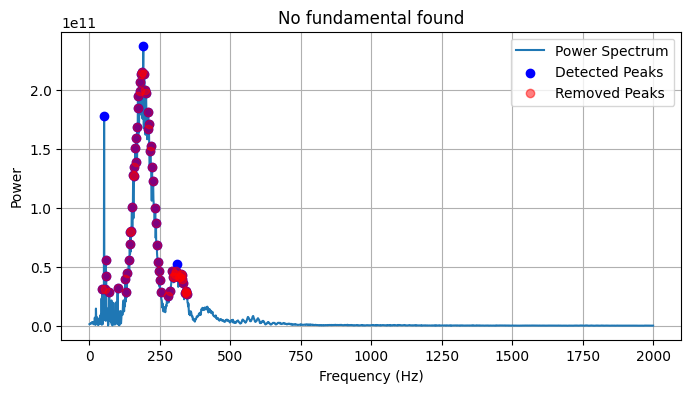

0.5


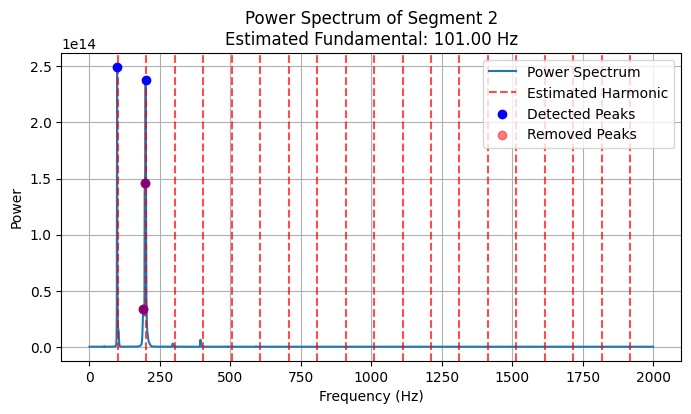

1.0


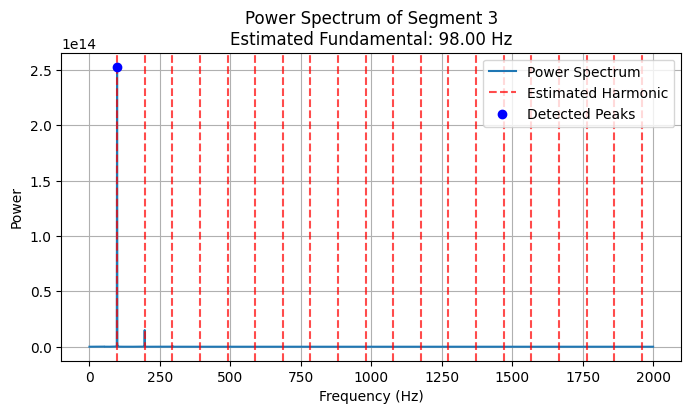

1.0


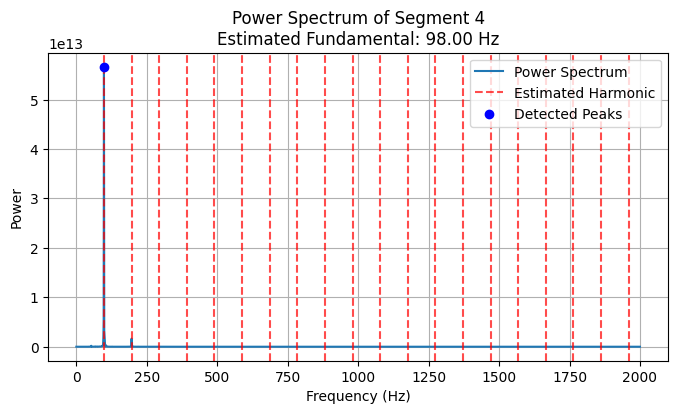

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import find_peaks
from lookups import note_to_frequency, note_to_fretboard  # Import lookup functions

# Load the WAV file
filename = "samples/E_3.wav"  # Replace with your actual file
lowest_freq = 70  # Minimum valid frequency for fundamental detection
highest_freq = 1000

# Load WAV file
sample_rate, data = wavfile.read(filename)

# Convert to mono if stereo
if len(data.shape) > 1:
    data = np.mean(data, axis=1)  # Convert stereo to mono

# Define segment duration (can be a float)
segment_duration = 1  # seconds (example with a non-integer value)
samples_per_segment = int(round(segment_duration * sample_rate))  # Ensure it's an integer

# Trim data to be a multiple of the segment duration
num_segments = len(data) // samples_per_segment
trimmed_data = data[:num_segments * samples_per_segment]

def estimate_fundamental(peaks, power_values):
    """Finds the approximate fundamental frequency from detected peaks using an approximate GCD method.
    
    Removes peaks that are too close together (< 68 Hz), keeping the stronger peak. 
    After estimating the fundamental frequency, checks whether all remaining peaks are integer multiples of it.
    """
    filter_threshold = 0.4
    npeaks_unfiltered = len(peaks)
    
    # Sort peaks and power values together
    sorted_indices = np.argsort(peaks)
    peaks_sorted = peaks[sorted_indices]
    power_sorted = power_values[sorted_indices]
    
    removed_peaks = []  # Store removed peaks for plotting
    removed_power = []

    # Iteratively remove peaks that are too close (< 68 Hz)
    while True:
        if len(peaks_sorted) < 2:
            break
        
        spacings = np.diff(peaks_sorted)
        min_spacing_idx = np.argmin(spacings)
        min_spacing = spacings[min_spacing_idx]

        if min_spacing >= lowest_freq:
            break
        
        # Determine which peak to remove (weaker one)
        if power_sorted[min_spacing_idx] < power_sorted[min_spacing_idx + 1]:
            remove_idx = min_spacing_idx
        else:
            remove_idx = min_spacing_idx + 1

        # Store removed peaks for visualization
        removed_peaks.append(peaks_sorted[remove_idx])
        removed_power.append(power_sorted[remove_idx])

        # Remove the peak with lower power
        peaks_sorted = np.delete(peaks_sorted, remove_idx)
        power_sorted = np.delete(power_sorted, remove_idx)

    npeaks_filtered = len(peaks_sorted)
    filter_reduction = npeaks_filtered / npeaks_unfiltered
    print(filter_reduction)
    if filter_reduction < filter_threshold:
        return None, None, removed_peaks, removed_power
    
    if len(peaks_sorted) == 1:
        estimated_fundamental = peaks_sorted[0]
        if lowest_freq <= estimated_fundamental <= highest_freq:
            return peaks_sorted, peaks_sorted[0], removed_peaks, removed_power
        else:
            return None, None, removed_peaks, removed_power
    
    # Compute frequency differences
    spacings = np.diff(peaks_sorted)
    min_spacing = np.min(spacings)
    multiples = spacings / min_spacing

    threshold = 0.05
    rounded_multiples = np.round(multiples)
    valid_multiples = rounded_multiples[np.abs(multiples - rounded_multiples) <= threshold]

    # Filter spacings and divide by corresponding valid multiples
    valid_indices = np.abs(multiples - rounded_multiples) <= threshold
    filtered_spacings = spacings[valid_indices]
    normalized_spacings = filtered_spacings / valid_multiples

    # Compute the average of normalized spacings
    if len(normalized_spacings) > 0:
        estimated_fundamental = np.mean(normalized_spacings)
    else:
        return None, None, removed_peaks, removed_power

    # **Final Validation: Check if all peaks are integer multiples of the fundamental**
    peak_multiples = peaks_sorted / estimated_fundamental
    rounded_peak_multiples = np.round(peak_multiples)
    valid_peak_multiples = np.abs(peak_multiples - rounded_peak_multiples) <= threshold

    if not np.all(valid_peak_multiples):
        return None, None, removed_peaks, removed_power

    if lowest_freq <= estimated_fundamental <= highest_freq:
        return peaks_sorted, estimated_fundamental, removed_peaks, removed_power
    else:    
        return None, None, removed_peaks, removed_power

# Process each segment
for i in range(num_segments):
    segment = trimmed_data[i * samples_per_segment : (i + 1) * samples_per_segment]
    
    # Compute FFT
    fft_result = np.fft.fft(segment)
    freqs = np.fft.fftfreq(len(segment), 1/sample_rate)
    
    # Get power spectrum (magnitude squared of FFT)
    power_spectrum = np.abs(fft_result) ** 2
    
    # Only keep frequencies up to 2000 Hz
    mask = (freqs >= 0) & (freqs <= 2000)
    freqs = freqs[mask]
    power_spectrum = power_spectrum[mask]

    # Find prominent peaks in the power spectrum
    peak_indices, _ = find_peaks(power_spectrum, height=max(power_spectrum) * 0.1)
    peak_frequencies = freqs[peak_indices]
    power_values = power_spectrum[peak_indices]

    # Estimate fundamental frequency
    true_peaks, estimated_fundamental, removed_peaks, removed_power = estimate_fundamental(peak_frequencies, power_values)

    # Plot power spectrum
    plt.figure(figsize=(8, 4))
    plt.plot(freqs, power_spectrum, label="Power Spectrum")

    # Overlay harmonic markers
    if estimated_fundamental:
        harmonics = [estimated_fundamental * i for i in range(1, 2000 // int(estimated_fundamental) + 1)]
        for h in harmonics:
            plt.axvline(x=h, color="r", linestyle="--", alpha=0.7, label="Estimated Harmonic" if h == harmonics[0] else "")

    # Plot detected peaks in **blue**
    plt.scatter(peak_frequencies, power_values, color='blue', label="Detected Peaks", zorder=3)

    # Plot **removed peaks** in **red** with transparency
    if removed_peaks:
        plt.scatter(removed_peaks, removed_power, color='red', alpha=0.5, label="Removed Peaks", zorder=3)

    plt.title(f"Power Spectrum of Segment {i + 1}\nEstimated Fundamental: {estimated_fundamental:.2f} Hz" if estimated_fundamental else "No fundamental found")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.legend()
    plt.grid()
    plt.show()


None


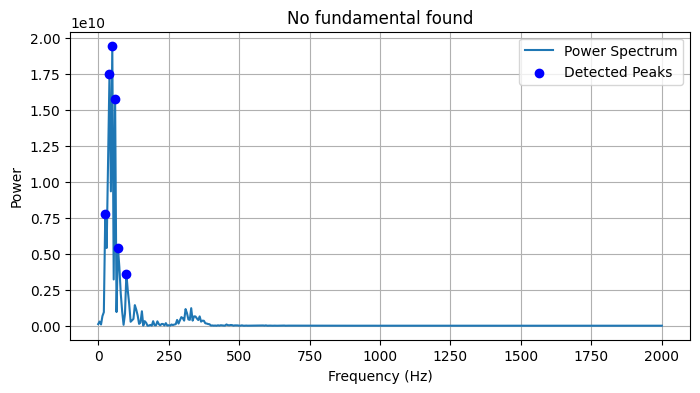

None


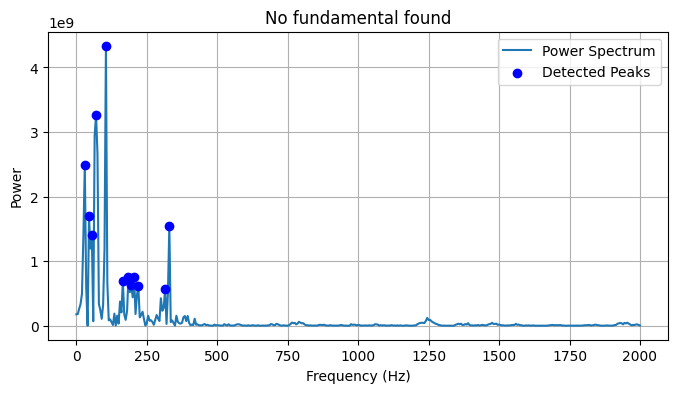

None


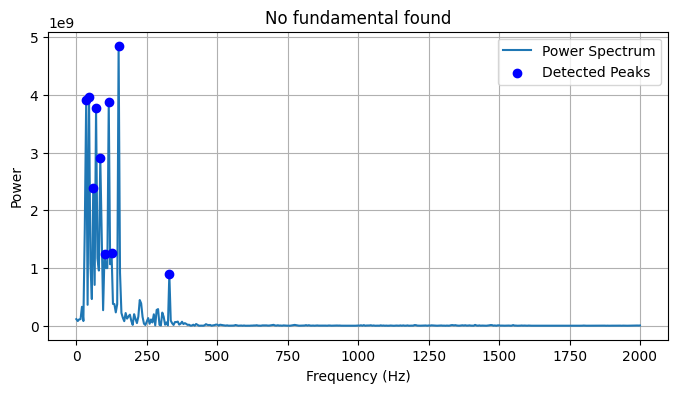

None


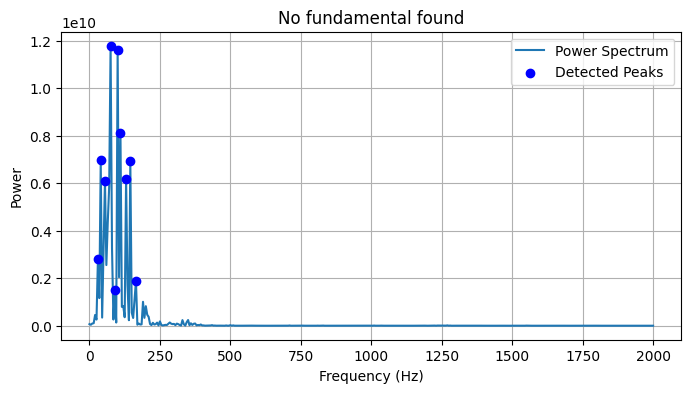

None


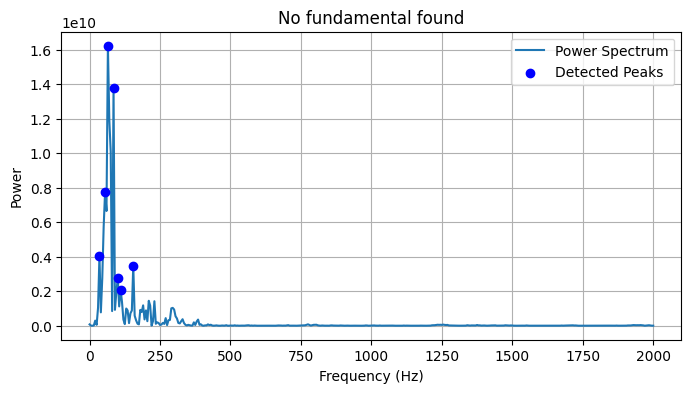

[70.]


TypeError: unsupported format string passed to numpy.ndarray.__format__

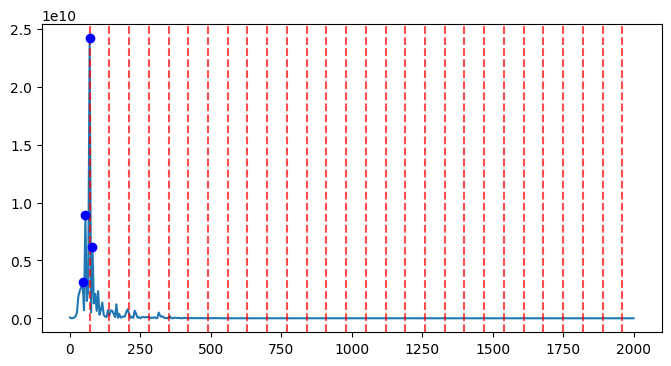

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import find_peaks
from math import gcd
from functools import reduce
from lookups import note_to_frequency
from lookups import note_to_fretboard

# Load the WAV file
filename = "samples/EH_5.wav"  # Replace with your actual file
lowest_freq = 70

# Load WAV file
sample_rate, data = wavfile.read(filename)

# Convert to mono if stereo
if len(data.shape) > 1:
    data = np.mean(data, axis=1)  # Convert stereo to mono

# Define segment duration (can be a float)
segment_duration = 0.2  # seconds (example with a non-integer value)
samples_per_segment = int(round(segment_duration * sample_rate))  # Ensure it's an integer

# Trim data to be a multiple of the segment duration
num_segments = len(data) // samples_per_segment
trimmed_data = data[:num_segments * samples_per_segment]

def estimate_fundamental(peaks, power_values):
    """Finds the approximate fundamental frequency from detected peaks using an approximate GCD method."""
    filter_threshold = 0.4

    npeaks_unfiltered = len(peaks)
    
    # Iteratively remove peaks with spacing < 68 Hz
    sorted_indices = np.argsort(peaks)
    peaks_sorted = peaks[sorted_indices]
    power_sorted = power_values[sorted_indices]

    while True:
        if len(peaks_sorted) < 2:
            break
        
        spacings = np.diff(peaks_sorted)

        # Find the smallest spacing
        min_spacing_idx = np.argmin(spacings)
        min_spacing = spacings[min_spacing_idx]

        if min_spacing >= lowest_freq:  # Stop if all spacings are >= 68 Hz
            break
        
        # Determine which peak to remove (weaker one)
        if power_sorted[min_spacing_idx] < power_sorted[min_spacing_idx + 1]:
            remove_idx = min_spacing_idx
        else:
            remove_idx = min_spacing_idx + 1

        # Remove the peak with lower power
        peaks_sorted = np.delete(peaks_sorted, remove_idx)
        power_sorted = np.delete(power_sorted, remove_idx)

    if len(peaks_sorted) == 1:
        if (peaks_sorted[0]) < lowest_freq:
            return None, None
        else:
            return peaks_sorted, peaks_sorted[0]
    
    npeaks_filtered = len(peaks_sorted)
    filter_reduction = npeaks_filtered / npeaks_unfiltered
    if filter_reduction < filter_threshold:
        return None, None
    
    # Compute frequency differences
    spacings = np.diff(peaks_sorted)
    print("Spacings:", spacings)

    min_spacing = np.min(spacings)
    multiples = spacings / min_spacing
    print("Multiples:", multiples)

    threshold = 0.05
    rounded_multiples = np.round(multiples)
    valid_multiples = rounded_multiples[np.abs(multiples - rounded_multiples) <= threshold]
    print("Valid Multiples:", valid_multiples)

    # Filter spacings and divide by corresponding valid multiples
    valid_indices = np.abs(multiples - rounded_multiples) <= threshold
    filtered_spacings = spacings[valid_indices]
    normalized_spacings = filtered_spacings / valid_multiples
    print("Normalized Spacings:", normalized_spacings)

    # Compute the average of normalized spacings
    if len(normalized_spacings) > 0:
        average_spacing = np.mean(normalized_spacings)
        print("Average Normalized Spacing:", average_spacing)
    else:
        average_spacing = None, None

    peak_multiples = peaks_sorted / estimated_fundamental
    rounded_peak_multiples = np.round(peak_multiples)
    valid_peak_multiples = np.abs(peak_multiples - rounded_peak_multiples) <= threshold

    if not np.all(valid_peak_multiples):
        print("Validation failed: Some peaks are not integer multiples.")
        return None, None
    
    if average_spacing < lowest_freq:
        return None, None

    return peaks_sorted, average_spacing

# Process each segment
for i in range(num_segments):
    segment = trimmed_data[i * samples_per_segment : (i + 1) * samples_per_segment]
    
    # Compute FFT
    fft_result = np.fft.fft(segment)
    freqs = np.fft.fftfreq(len(segment), 1/sample_rate)
    
    # Get power spectrum (magnitude squared of FFT)
    power_spectrum = np.abs(fft_result) ** 2
    
    # Only keep frequencies up to 1000 Hz
    mask = (freqs >= 0) & (freqs <= 2000)  # Keep positive frequencies up to 1000 Hz
    freqs = freqs[mask]
    power_spectrum = power_spectrum[mask]

    # Find prominent peaks in the power spectrum
    peak_indices, _ = find_peaks(power_spectrum, height=max(power_spectrum) * 0.1)  # Detect peaks above 10% max power
    peak_frequencies = freqs[peak_indices]
    power_values = power_spectrum[peak_indices]

    # Estimate fundamental frequency
    estimated_fundamental, true_peaks = estimate_fundamental(peak_frequencies, power_values)
    print(estimated_fundamental)
    
    # Plot power spectrum
    plt.figure(figsize=(8, 4))
    plt.plot(freqs, power_spectrum, label="Power Spectrum")

    # Overlay harmonic markers
    if estimated_fundamental:
        harmonics = [estimated_fundamental * i for i in range(1, 2000 // int(estimated_fundamental) + 1)]
        for h in harmonics:
            plt.axvline(x=h, color="r", linestyle="--", alpha=0.7, label="Estimated Harmonic" if h == harmonics[0] else "")

    plt.scatter(peak_frequencies, power_spectrum[peak_indices], color='blue', label="Detected Peaks", zorder=3)

    plt.title(f"Power Spectrum of Segment {i + 1}\nEstimated Fundamental: {estimated_fundamental:.2f} Hz" if estimated_fundamental else "No fundamental found")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.legend()
    plt.grid()
    plt.show()
